In [1]:
from tkinter import filedialog
from tkinter import Tk
import numpy as np
import pandas as pd
import umap
from sklearn.preprocessing import LabelEncoder
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KernelDensity
from scipy.spatial import ConvexHull, Delaunay
import shap
import xgboost as xgb
import alphashape

root = Tk()
root.withdraw()

# read data
csv_file_path = filedialog.askopenfilename(title="Select Test-Data file", filetypes=(("CSV files", "*.csv"), ("All files", "*.*")))
Setting_File_path = filedialog.askopenfilename(title="Select Setting-file", filetypes=(("Excel files", "*.xlsx"), ("All files", "*.*")))

# df define
df = pd.read_csv(csv_file_path)
df_setting = pd.read_excel(Setting_File_path)

feature_vars = df_setting.loc[df_setting['Analysis_List'].notna(), 'Analysis_List'].tolist()
target_variable = df_setting.loc[df_setting['Target_Variable'].notna(), 'Target_Variable'].values[0]

# mode check @ test-Data
mode_data = df["Mode"]
unique_modes = mode_data.drop_duplicates().tolist()
print("Unique Modes:", unique_modes)

# data define
target_mode = "2wfF4"
train_df = df[df['Mode'] != target_mode]
test_df = df[df['Mode'] == target_mode]

train_data = train_df[feature_vars]
test_data = test_df[feature_vars]
target_data = train_df[target_variable]


# Unique Modes: ['USHWY', 'JC08', 'LA4', 'US06', '2WFf3kai', '2wfF4', 'VHmn', '2FJ']

Unique Modes: ['USHWY', 'JC08', 'LA4', 'US06', '2WFf3kai', '2wfF4', 'VHmn', '2FJ']


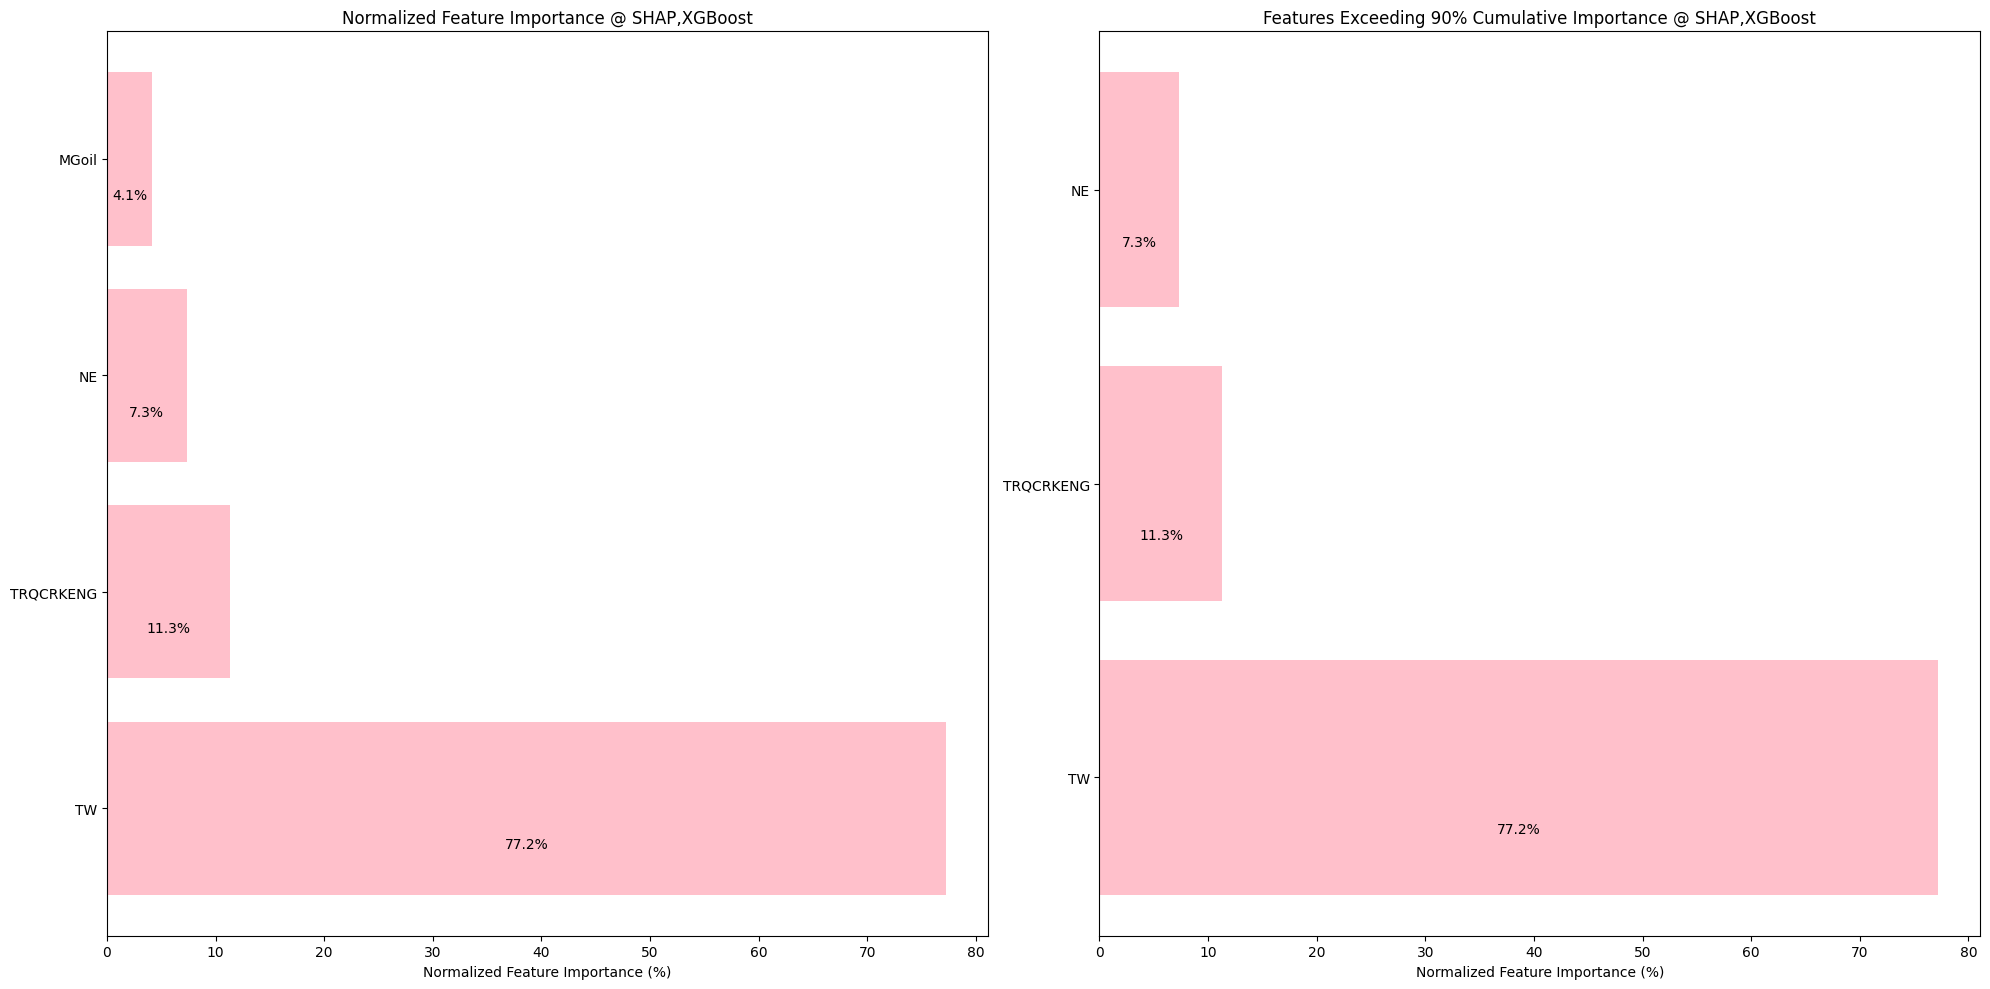

In [2]:
# モデル訓練
model = xgb.XGBRegressor(n_jobs=-1)
model.fit(train_data, target_data)

# SHAP値の計算
explainer = shap.Explainer(model)
shap_values = explainer(train_data)

# 特徴量の重要度とソート
feature_importance = np.abs(shap_values.values).mean(axis=0)
sorted_idx = np.argsort(-feature_importance)
sorted_importance = feature_importance[sorted_idx]

# 正規化
normalized_importance = (sorted_importance / np.sum(sorted_importance)) * 100

# 累計寄与度が90%を超えるまでの特徴量を選択
cumulative_importance = np.cumsum(sorted_importance / np.sum(sorted_importance))
selected_features_idx = np.where(cumulative_importance > 0.9)[0][0]
selected_features = [feature_vars[sorted_idx[i]] for i in range(selected_features_idx + 1)]
selected_normalized_importance = normalized_importance[:selected_features_idx + 1]

# 1行2列でプロット
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# すべての特徴量を表示
axes[0].barh(range(len(sorted_idx)), normalized_importance, align='center', color='pink')
axes[0].set_yticks(range(len(sorted_idx)))
axes[0].set_yticklabels([feature_vars[i] for i in sorted_idx])
axes[0].set_xlabel('Normalized Feature Importance (%)')
axes[0].set_title('Normalized Feature Importance @ SHAP,XGBoost')

bars = axes[0].patches
for bar in bars:
    axes[0].text(bar.get_width() * 0.5, bar.get_y() + bar.get_height()/4,
                f"{bar.get_width():.1f}%", color="black", fontsize=10, ha='center', va='bottom')

# 累計寄与度が90%を超える特徴量だけを表示
axes[1].barh(range(len(selected_features)), selected_normalized_importance, align='center', color='pink')
axes[1].set_yticks(range(len(selected_features)))
axes[1].set_yticklabels([feature_vars[sorted_idx[i]] for i in range(selected_features_idx + 1)])
axes[1].set_xlabel('Normalized Feature Importance (%)')
axes[1].set_title('Features Exceeding 90% Cumulative Importance @ SHAP,XGBoost')

bars = axes[1].patches
for bar in bars:
    axes[1].text(bar.get_width() * 0.5, bar.get_y() + bar.get_height()/4,
                f"{bar.get_width():.1f}%", color="black", fontsize=10, ha='center', va='bottom')

plt.tight_layout()
plt.show()


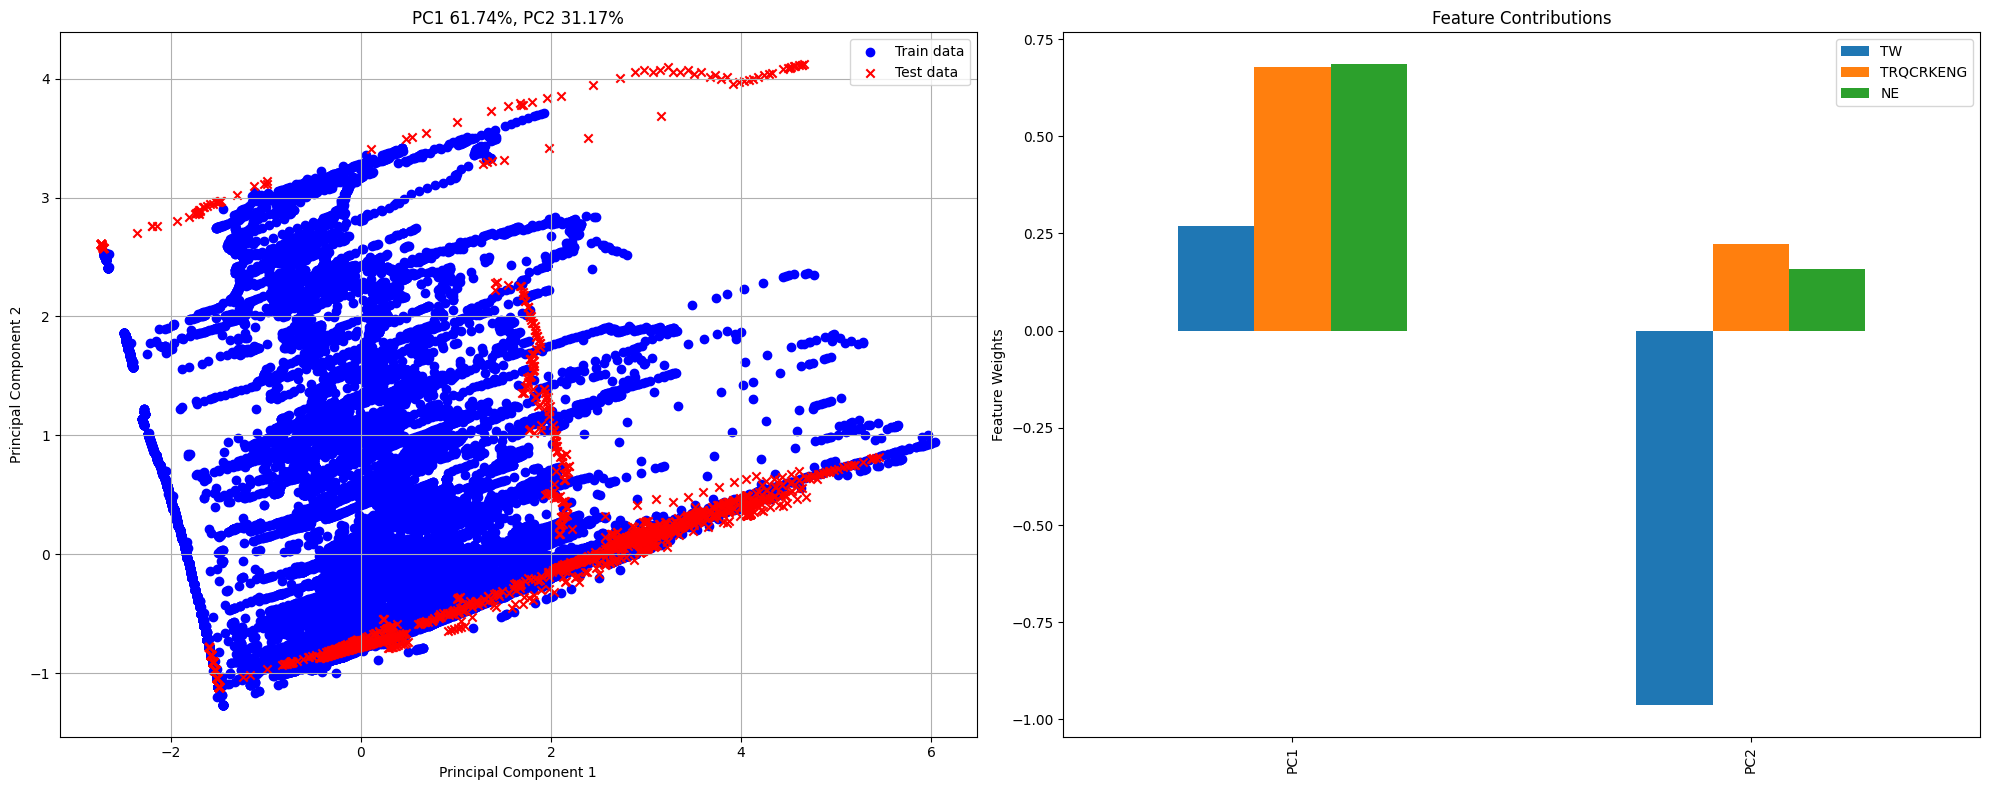

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

scaler = StandardScaler()
selected_train_data = scaler.fit_transform(train_data[selected_features])
selected_test_data = scaler.transform(test_data[selected_features])

# PCA
pca = PCA(n_components=0.9)
pca_train_data = pca.fit_transform(selected_train_data)
pca_test_data = pca.transform(selected_test_data)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Visualize PCA
ax = axes[0]
ax.scatter(pca_train_data[:, 0], pca_train_data[:, 1], c='blue', marker='o', label='Train data')
ax.scatter(pca_test_data[:, 0], pca_test_data[:, 1], c='red', marker='x', label='Test data') 
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')

# 分散寄与度計算
explained_variance_ratio = pca.explained_variance_ratio_
explained_variance_ratio1 = explained_variance_ratio[0] * 100
explained_variance_ratio2 = explained_variance_ratio[1] * 100

ax.set_title(f'PC1 {explained_variance_ratio1:.2f}%, PC2 {explained_variance_ratio2:.2f}%')
ax.legend(loc='upper right')
ax.grid(True)

# feature contribution
components_df = pd.DataFrame(pca.components_, columns=selected_features, index=[f'PC{i+1}' for i in range(len(pca.components_))])

# Visualize
ax = axes[1]
components_df.iloc[:2, :].plot(kind='bar', ax=ax)
ax.set_title('Feature Contributions')
ax.set_ylabel('Feature Weights')

plt.tight_layout()
plt.show()


For alpha=0, number of outsider_test_indices: 115
For alpha=0, number of boundary_train_indices: 199
For alpha=1, number of outsider_test_indices: 637
For alpha=1, number of boundary_train_indices: 2758
For alpha=2, number of outsider_test_indices: 643
For alpha=2, number of boundary_train_indices: 3345
For alpha=3, number of outsider_test_indices: 649
For alpha=3, number of boundary_train_indices: 3498


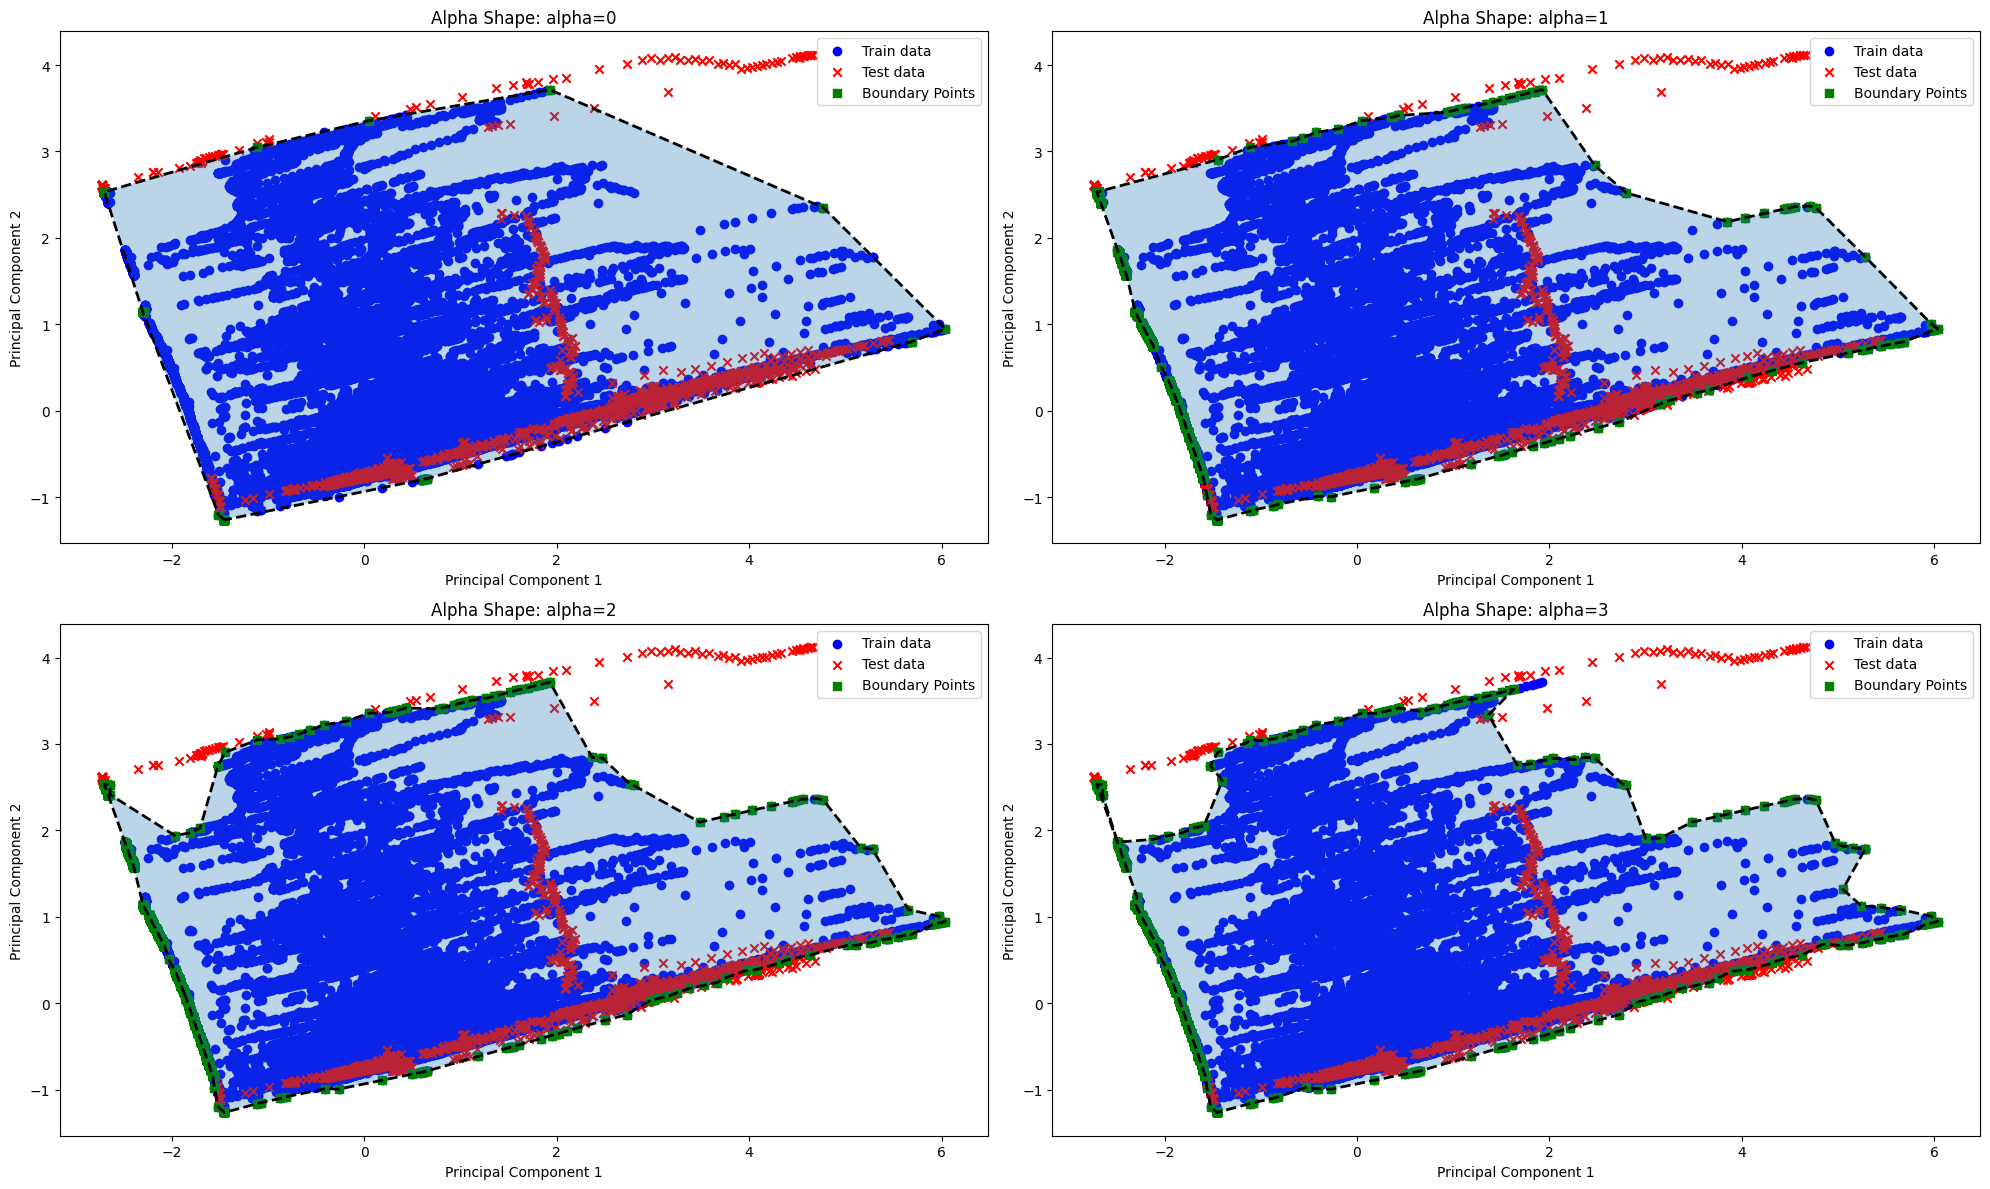

In [4]:
from shapely.geometry import MultiPoint, Point, shape
from alphashape import alphashape

# alpha_shape外形に対しpointとの距離がthresholdよりも小さければTrueを返す
def is_near_boundary(point, alpha_shape, threshold=1e-5):
    point = Point(point)
    return alpha_shape.boundary.distance(point) < threshold

# Initialize
outsider_test_points = {}
boundary_train_points = {}
original_boundary_train_points = {}
original_outsider_test_points = {}


fig, axes = plt.subplots(2, 2, figsize=(20, 12))

for i, alpha_value in enumerate(range(0, 4)):
    ax = axes[i//2, i%2]
    alpha_shape = alphashape(pca_train_data, alpha=alpha_value)
    
    # outside : alpha shape
    outsider_test_indices = [not alpha_shape.contains(Point(point)) for point in pca_test_data]
    outsider_test_points[alpha_value] = pca_test_data[np.where(outsider_test_indices)]
    
    # boundary : alpha shape
    boundary_train_indices = [is_near_boundary(point, alpha_shape) for point in pca_train_data]
    boundary_train_points[alpha_value] = pca_train_data[np.where(boundary_train_indices)]
    
    print(f"For alpha={alpha_value}, number of outsider_test_indices: {np.sum(outsider_test_indices)}")
    print(f"For alpha={alpha_value}, number of boundary_train_indices: {np.sum(boundary_train_indices)}")

    # 元の特徴空間でのデータ
    original_boundary_train_indices = np.where(boundary_train_indices)[0]
    original_boundary_train_points[alpha_value] = scaler.inverse_transform(selected_train_data[original_boundary_train_indices])

    # 元の特徴空間でのデータ
    original_outsider_test_points[alpha_value] = test_data[selected_features].iloc[np.where(outsider_test_indices)[0]]

    # Plotting
    ax.scatter(pca_train_data[:, 0], pca_train_data[:, 1], c='blue', marker='o', label='Train data')
    ax.scatter(pca_test_data[:, 0], pca_test_data[:, 1], c='red', marker='x', label='Test data')
    ax.scatter(boundary_train_points[alpha_value][:, 0], boundary_train_points[alpha_value][:, 1], c='green', marker='s', label='Boundary Points')
    #ax.scatter(outsider_test_points[alpha_value][:, 0], outsider_test_points[alpha_value][:, 1], c='purple', marker='^', label='Outsider Test Points')

    if alpha_shape.geom_type == 'Polygon':
        ax.plot(*alpha_shape.exterior.xy, c='k', linestyle='--', lw=2)
        ax.fill(*alpha_shape.exterior.xy, alpha=0.3)
    elif alpha_shape.geom_type == 'MultiPolygon':
        for shape in alpha_shape:
            ax.plot(*shape.exterior.xy, c='k', linestyle='--', lw=2)
            ax.fill(*shape.exterior.xy, alpha=0.3)

    ax.set_title(f'Alpha Shape: alpha={alpha_value}')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.legend()

plt.tight_layout()
plt.show()


In [5]:
from scipy.spatial import ConvexHull, Delaunay
import plotly.graph_objects as go
import numpy as np

# binary search
def find_optimal_layers(points, test_points, target_inclusion_rate):
    min_difference = float('inf')
    optimal_layers = 0
    
    lower_bound = 0
    upper_bound = 150

    while lower_bound <= upper_bound:
        num_layers = (lower_bound + upper_bound) // 2
        temp_points = points.copy()
        
        for _ in range(num_layers):
            hull = ConvexHull(temp_points)
            temp_points = np.delete(temp_points, hull.vertices, axis=0)
            
            if len(temp_points) == 0:
                break
        
        hull = ConvexHull(temp_points)
        deln = Delaunay(temp_points[hull.vertices])
        is_inside = deln.find_simplex(test_points) >= 0
        inclusion_rate = np.sum(is_inside) / len(test_points)
        
        difference = abs(target_inclusion_rate - inclusion_rate)
        
        if difference < min_difference:
            min_difference = difference
            optimal_layers = num_layers

        if inclusion_rate < target_inclusion_rate:
            upper_bound = num_layers - 1
        else:
            lower_bound = num_layers + 1
            
    return optimal_layers

# Prepare data
train_data_np = train_data[selected_features].to_numpy()
test_data_np = test_data[selected_features].to_numpy()

# Find the optimal layers to remove
target_inclusion_rate = 0.9
optimal_layers = find_optimal_layers(train_data_np, test_data_np, target_inclusion_rate)

# Remove the optimal layers
points = train_data_np.copy()
for _ in range(optimal_layers):
    hull = ConvexHull(points)
    points = np.delete(points, hull.vertices, axis=0)

# Compute final ConvexHull
final_hull = ConvexHull(points)
final_boundary_points = points[final_hull.vertices, :]


# Calculate outsider test points
deln = Delaunay(points[final_hull.vertices])
is_inside = deln.find_simplex(test_data_np) >= 0
outsider_test_points = test_data_np[~is_inside]


# Plotting
fig = go.Figure()

# Plot original train data
fig.add_trace(go.Scatter3d(x=train_data_np[:, 0],
                           y=train_data_np[:, 1],
                           z=train_data_np[:, 2],
                           mode='markers',
                           marker=dict(size=4, color='green'),
                           name='Original Train Data'))

# Plot original test data
fig.add_trace(go.Scatter3d(x=test_data_np[:, 0],
                           y=test_data_np[:, 1],
                           z=test_data_np[:, 2],
                           mode='markers',
                           marker=dict(size=4, color='red'),
                           name='Original Test Data'))

# Plot boundary points after removing layers
fig.add_trace(go.Scatter3d(x=final_boundary_points[:, 0],
                           y=final_boundary_points[:, 1],
                           z=final_boundary_points[:, 2],
                           mode='markers',
                           marker=dict(size=4, color='blue'),
                           name=f'Boundary Points (remove {optimal_layers} layers)'))

# Plot outsider test points
fig.add_trace(go.Scatter3d(x=outsider_test_points[:, 0],
                           y=outsider_test_points[:, 1],
                           z=outsider_test_points[:, 2],
                           mode='markers',
                           marker=dict(size=4, color='purple'),
                           name='Outsider Test Points'))


# Convex hull in 3D requires at least 4 points
if len(points) >= 4: 
    fig.add_trace(go.Mesh3d(x=points[:, 0],
                            y=points[:, 1],
                            z=points[:, 2],
                            i=final_hull.simplices[:, 0],
                            j=final_hull.simplices[:, 1],
                            k=final_hull.simplices[:, 2],
                            opacity=0.6,
                            color='orange'))

# Set axis labels
fig.update_layout(scene=dict(xaxis_title=selected_features[0],
                             yaxis_title=selected_features[1],
                             zaxis_title=selected_features[2]),
                  title=f'Convex Hull(Inclusion:{np.sum(is_inside)/len(test_data_np)*100:.1f}%)')

#fig.show()

# Save as HTML
fig.write_html(f"Convex Hull(Inclusion_{np.sum(is_inside)/len(test_data_np)*100:.1f}%).html")

In [16]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from scipy.spatial import ConvexHull, Delaunay
import itertools
import pyDOE2

# 特徴量の数や最大値、最小値を取得する
feature_ranges = {feature: (train_data[feature].min(), train_data[feature].max()) 
                  for feature in selected_features}

# 特徴量の数によってフルファクトリアルかBBDを実行
if len(selected_features) <= 6:
    # フルファクトリアルデザインを使用
    levels = [np.array([mn, mx]) for mn, mx in feature_ranges.values()]
    full_factorial_design = np.array(list(itertools.product(*levels)))
    experiment_design_df = pd.DataFrame(full_factorial_design, columns=selected_features)
else:
    # BBDを使用
    num_factors = len(selected_features)
    bbd_design = pyDOE2.bbdesign(num_factors, center=1)
    scaled_design = np.zeros_like(bbd_design)
    for i, (feature, (min_val, max_val)) in enumerate(feature_ranges.items()):
        scaled_design[:, i] = bbd_design[:, i] * (max_val - min_val) / 2 + (max_val + min_val) / 2
    experiment_design_df = pd.DataFrame(scaled_design, columns=selected_features)

# 既存のスクリプトに統合
train_data_np = train_data[selected_features].to_numpy()
test_data_np = test_data[selected_features].to_numpy()

# 各種データと実験計画をプロットするために変換
experiment_design_np = experiment_design_df.to_numpy()


# Plotting
fig = go.Figure()

# Plot original train data
fig.add_trace(go.Scatter3d(x=train_data_np[:, 0],
                           y=train_data_np[:, 1],
                           z=train_data_np[:, 2],
                           mode='markers',
                           marker=dict(size=4, color='green'),
                           name='Original Train Data'))

# Plot original test data
fig.add_trace(go.Scatter3d(x=test_data_np[:, 0],
                           y=test_data_np[:, 1],
                           z=test_data_np[:, 2],
                           mode='markers',
                           marker=dict(size=4, color='red'),
                           name='Original Test Data'))

# Plot boundary points after removing layers
fig.add_trace(go.Scatter3d(x=final_boundary_points[:, 0],
                           y=final_boundary_points[:, 1],
                           z=final_boundary_points[:, 2],
                           mode='markers',
                           marker=dict(size=4, color='blue'),
                           name=f'Boundary Points (remove {optimal_layers} layers)'))

# Plot outsider test points
fig.add_trace(go.Scatter3d(x=outsider_test_points[:, 0],
                           y=outsider_test_points[:, 1],
                           z=outsider_test_points[:, 2],
                           mode='markers',
                           marker=dict(size=4, color='purple'),
                           name='Outsider Test Points'))


# Convex hull in 3D requires at least 4 points
if len(points) >= 4: 
    fig.add_trace(go.Mesh3d(x=points[:, 0],
                            y=points[:, 1],
                            z=points[:, 2],
                            i=final_hull.simplices[:, 0],
                            j=final_hull.simplices[:, 1],
                            k=final_hull.simplices[:, 2],
                            opacity=0.6,
                            color='orange'))


# End Point
fig.add_trace(go.Scatter3d(x=experiment_design_np[:, 0],
                           y=experiment_design_np[:, 1],
                           z=experiment_design_np[:, 2],
                           mode='markers',
                           marker=dict(size=5, color='black'),
                           name='EndPoint'))

# Set axis labels
fig.update_layout(scene=dict(xaxis_title=selected_features[0],
                             yaxis_title=selected_features[1],
                             zaxis_title=selected_features[2]),
                  title=f'Convex Hull+DOE(Inclusion:{np.sum(is_inside)/len(test_data_np)*100:.1f}%)')


# HTMLとして出力
fig.write_html(f"Convex Hull+DOE(Inclusion_{np.sum(is_inside)/len(test_data_np)*100:.1f}%).html")


In [18]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from scipy.spatial import ConvexHull, Delaunay
import itertools
import pyDOE2

# 特徴量の数や最大値、最小値を取得する
feature_ranges = {feature: (train_data[feature].min(), train_data[feature].max()) 
                  for feature in selected_features}


# 特徴量の数によってフルファクトリアルかBBDを実行
if len(selected_features) <= 6:
    # フルファクトリアルデザインを使用
    levels = [np.array([mn, mx]) for mn, mx in feature_ranges.values()]
    full_factorial_design = np.array(list(itertools.product(*levels)))
    experiment_design_df = pd.DataFrame(full_factorial_design, columns=selected_features)
else:
    # BBDを使用
    num_factors = len(selected_features)
    bbd_design = pyDOE2.bbdesign(num_factors, center=1)
    scaled_design = np.zeros_like(bbd_design)
    for i, (feature, (min_val, max_val)) in enumerate(feature_ranges.items()):
        scaled_design[:, i] = bbd_design[:, i] * (max_val - min_val) / 2 + (max_val + min_val) / 2
    experiment_design_df = pd.DataFrame(scaled_design, columns=selected_features)

# 既存のスクリプトに統合
train_data_np = train_data[selected_features].to_numpy()
test_data_np = test_data[selected_features].to_numpy()

# 各種データと実験計画をプロットするために変換
experiment_design_np = experiment_design_df.to_numpy()


# Delaunayオブジェクトの作成（外挿境界面）
if final_hull.points.shape[0] >= 4:  # 凸包の頂点が4つ以上ないとDelaunayオブジェクトは作成できない
    hull = Delaunay(final_hull.points[final_hull.vertices])

# LHSで外挿境界面の外側の空間にサンプリングする関数
def lhs_outside_hull(num_samples, hull, feature_ranges, existing_samples):
    samples_outside_hull = []
    while len(samples_outside_hull) < num_samples:
        # 特徴量の範囲が適切であることを確認
        if not feature_ranges or len(feature_ranges) == 0:
            raise ValueError("特徴量の範囲が空または未定義です。")
        
        # LHSサンプリング
        lhs_sample = pyDOE2.lhs(len(feature_ranges), samples=1, criterion='maximin')
        
        # 特徴量範囲に基づいてサンプルをスケール
        min_bounds = np.array([fr[0] for fr in feature_ranges])
        max_bounds = np.array([fr[1] for fr in feature_ranges])
        lhs_sample = min_bounds + (max_bounds - min_bounds) * lhs_sample

        # サンプルが既存の凸包の外側にあるかどうかをチェック
        if hull and not in_hull(lhs_sample, hull):
            samples_outside_hull.append(lhs_sample)
    
    return np.array(samples_outside_hull)

# 凸包が適切であるか確認する
if hull is not None and hull.points.shape[0] < 4:
    raise ValueError("凸包が無効です。凸包を形成するには最低4点必要です。")


# LHSサンプリングの実行
num_additional_samples = 100  # 追加するサンプル数
if final_hull.points.shape[0] >= 4:  # 凸包が有効な場合のみサンプリング実行
    additional_samples = lhs_outside_hull(num_additional_samples, hull, feature_ranges, experiment_design_np)
else:
    additional_samples = lhs_outside_hull(num_additional_samples, None, feature_ranges, experiment_design_np)


# Plotting
fig = go.Figure()

# Plot original train data
fig.add_trace(go.Scatter3d(x=train_data_np[:, 0],
                           y=train_data_np[:, 1],
                           z=train_data_np[:, 2],
                           mode='markers',
                           marker=dict(size=4, color='green'),
                           name='Original Train Data'))

# Plot original test data
fig.add_trace(go.Scatter3d(x=test_data_np[:, 0],
                           y=test_data_np[:, 1],
                           z=test_data_np[:, 2],
                           mode='markers',
                           marker=dict(size=4, color='red'),
                           name='Original Test Data'))

# Plot boundary points after removing layers
fig.add_trace(go.Scatter3d(x=final_boundary_points[:, 0],
                           y=final_boundary_points[:, 1],
                           z=final_boundary_points[:, 2],
                           mode='markers',
                           marker=dict(size=4, color='blue'),
                           name=f'Boundary Points (remove {optimal_layers} layers)'))

# Plot outsider test points
fig.add_trace(go.Scatter3d(x=outsider_test_points[:, 0],
                           y=outsider_test_points[:, 1],
                           z=outsider_test_points[:, 2],
                           mode='markers',
                           marker=dict(size=4, color='purple'),
                           name='Outsider Test Points'))


# Convex hull in 3D requires at least 4 points
if len(points) >= 4: 
    fig.add_trace(go.Mesh3d(x=points[:, 0],
                            y=points[:, 1],
                            z=points[:, 2],
                            i=final_hull.simplices[:, 0],
                            j=final_hull.simplices[:, 1],
                            k=final_hull.simplices[:, 2],
                            opacity=0.6,
                            color='orange'))


# End Point
fig.add_trace(go.Scatter3d(x=experiment_design_np[:, 0],
                           y=experiment_design_np[:, 1],
                           z=experiment_design_np[:, 2],
                           mode='markers',
                           marker=dict(size=5, color='black'),
                           name='EndPoint'))


# LHS
fig.add_trace(go.Scatter3d(x=additional_samples[:, 0],
                           y=additional_samples[:, 1],
                           z=additional_samples[:, 2],
                           mode='markers',
                           marker=dict(size=5, color='yellow'),
                           name='LHS Additional Samples'))

# Set axis labels
fig.update_layout(scene=dict(xaxis_title=selected_features[0],
                             yaxis_title=selected_features[1],
                             zaxis_title=selected_features[2]),
                  title=f'Convex Hull+DOE(Inclusion:{np.sum(is_inside)/len(test_data_np)*100:.1f}%)')


# HTMLとして出力
fig.write_html(f"Convex Hull+DOE(Inclusion_{np.sum(is_inside)/len(test_data_np)*100:.1f}%).html")


ValueError: zero-size array to reduction operation minimum which has no identity

In [ ]:
## PCA空間で外挿境界定義⇒高次元にMapping⇒convex_hull

import plotly.graph_objects as go
from scipy.spatial import ConvexHull

fig = go.Figure()
alpha_value = 3

# Add scatter plot for original train data points
fig.add_trace(go.Scatter3d(x=train_data[selected_features].iloc[:, 0],
                           y=train_data[selected_features].iloc[:, 1],
                           z=train_data[selected_features].iloc[:, 2],
                           mode='markers',
                           marker=dict(size=4, color='green'),
                           name='Train Data'))

# Add scatter plot for original test data points
fig.add_trace(go.Scatter3d(x=test_data[selected_features].iloc[:, 0],
                           y=test_data[selected_features].iloc[:, 1],
                           z=test_data[selected_features].iloc[:, 2],
                           mode='markers',
                           marker=dict(size=4, color='red'),
                           name='Test Data'))

# Add scatter plot for original_boundary_train_points
fig.add_trace(go.Scatter3d(x=original_boundary_train_points[alpha_value][:, 0],
                           y=original_boundary_train_points[alpha_value][:, 1],
                           z=original_boundary_train_points[alpha_value][:, 2],
                           mode='markers',
                           marker=dict(size=4, color='blue'),
                           name='Boundary Points'))

# Calculate Convex Hull for original_boundary_train_points
boundary_points = original_boundary_train_points[alpha_value]
hull = ConvexHull(boundary_points)

# Add mesh for Convex Hull
fig.add_trace(go.Mesh3d(x=boundary_points[:, 0],
                         y=boundary_points[:, 1],
                         z=boundary_points[:, 2],
                         i=hull.simplices[:, 0],
                         j=hull.simplices[:, 1],
                         k=hull.simplices[:, 2],
                         opacity=0.4,
                         color='orange',
                         name='Convex Hull'))

# Add scatter plot for original_outsider_test_points
fig.add_trace(go.Scatter3d(x=original_outsider_test_points[alpha_value].iloc[:, 0],
                           y=original_outsider_test_points[alpha_value].iloc[:, 1],
                           z=original_outsider_test_points[alpha_value].iloc[:, 2],
                           mode='markers',
                           marker=dict(size=4, color='purple'),
                           name='Outsider Test Points'))

# Set axis label
fig.update_layout(scene=dict(xaxis_title=selected_features[0],
                             yaxis_title=selected_features[1],
                             zaxis_title=selected_features[2]),
                  title=f'3D_PCA-mapping_alpha={alpha_value}')

# Save & Show
fig.write_html(f"3D_PCA-mapping_alpha={alpha_value}.html")
#fig.show()
